# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


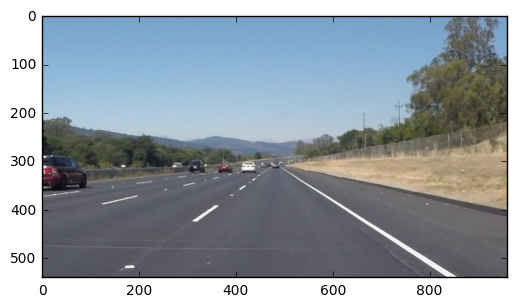

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def median_blur(img, kernel_size):  
    """Applies a Median Noise kernel"""
    return cv2.medianBlur(img, kernel_size)
    
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def get_y_intercept(lane_lines, slopes):
    slopes = slopes[~np.isnan(slopes)]
    slopes = slopes[~np.isinf(slopes)]
    avg_slope = slopes.mean()
    lane_lines = lane_lines.reshape((lane_lines.shape[0]*2, lane_lines.shape[1]//2))
    x_min, y_min = np.mean(lane_lines, axis=0)
    return y_min - (x_min*avg_slope), avg_slope

def get_x_intercepts(y_1, y_2, slope, b):
    if not (~np.isnan(slope) and ~np.isnan(b)):
        x_1 = x_2 = 0.0
    else:
        x_1 = (y_1 - b)/slope
        x_2 = (y_2 - b)/slope
    return x_1, x_2

prev_left_x1 = 0
prev_left_x2 = 0
prev_right_x1 = 0 
prev_right_x2 = 0 
prev_left_avg_m = 0
prev_right_avg_m = 0
pev_left_avg_m = -1
prev_right_avg_m = 1
prev_left_b = 0
prev_right_b = 0
prev_left_line = 0
prev_right_line = 0

def draw_lines_extrapolated(img, lines, color=[255, 0, 0], thickness=10):
    imgshape = img.shape
    lines = lines.reshape((lines.shape[0], lines.shape[2]))
    y_min = lines.reshape((lines.shape[0]*2, lines.shape[1]//2))[:,1].min()
    
    # slope= (    y2      -     y1   )/(    x2     -     x1    )  
    slopes = (lines[:,3] - lines[:,1])/(lines[:,2] - lines[:,0])
    slopes = slopes[~np.isinf(slopes)]
    slopes = slopes[~np.isnan(slopes)]
    left_lines = lines[slopes < -0.5]   # Left  lines should have negative slope, thershold=-0.5
    right_lines= lines[slopes > 0.5]   # Right lines should have positive slope, threshold=+0.5
    left_slopes = slopes[slopes < -0.5]
    right_slopes= slopes[slopes > 0.5]
    
    global prev_left_avg_m 
    global prev_right_avg_m 
    global prev_left_b
    global prev_right_b
    
    left_b, left_avg_m = get_y_intercept(left_lines, left_slopes)
    right_b, right_avg_m = get_y_intercept(right_lines, right_slopes)

    keep_prev_left = False
    keep_prev_right = False
    
    if left_avg_m < -0.83 or left_avg_m > -0.36:
        left_avg_m = prev_left_avg_m
        left_b = prev_left_b
        keep_prev_left = True
    if right_avg_m > 0.83 or right_avg_m < 0.36:
        right_avg_m = prev_right_avg_m
        right_b = prev_right_b
        keep_prev_right = True
       
    """
    # For challenge video
    if left_avg_m < -0.83 or left_avg_m > -0.57:
        left_avg_m = prev_left_avg_m
        left_b = prev_left_b
        keep_prev_left = True
    if right_avg_m > 0.83 or right_avg_m < 0.57:
        right_avg_m = prev_right_avg_m
        right_b = prev_right_b
        keep_prev_right = True
    """
  
    prev_left_avg_m = left_avg_m 
    prev_right_avg_m = right_avg_m
    prev_left_b = left_b
    prev_right_b = right_b
    
    # using y_min, avg_slope and y_intercept find x1 and x2
    left_x1, left_x2 = get_x_intercepts(y_1=y_min, y_2=imgshape[0], slope=left_avg_m, b=left_b)
    right_x1, right_x2 = get_x_intercepts(y_1=y_min, y_2=imgshape[0], slope=right_avg_m, b=right_b)
    
    ##  Apply first order filter ##
    global prev_left_x1
    global prev_left_x2
    global prev_right_x1 
    global prev_right_x2 

    if prev_left_x1 != 0 or prev_left_x2 != 0 or prev_right_x1 != 0 or prev_right_x2 !=0:
        alpha = 0.2
        left_x1_new = math.floor((alpha)*left_x1 + (1-alpha)*prev_left_x1)
        left_x2_new = math.floor((alpha)*left_x2 + (1-alpha)*prev_left_x2)
        right_x1_new = math.floor((alpha)*right_x1 + (1-alpha)*prev_right_x1)
        right_x2_new = math.floor((alpha)*right_x2 + (1-alpha)*prev_right_x2)
        prev_left_x1 = left_x1_new
        prev_left_x2 = left_x2_new
        prev_right_x1 = right_x1_new
        prev_right_x2 = right_x2_new
    else:
        left_x1_new = left_x1
        left_x2_new = left_x2
        right_x1_new = right_x1
        right_x2_new = right_x2
        prev_left_x1 = left_x1_new
        prev_left_x2 = left_x2_new
        prev_right_x1 = right_x1_new
        prev_right_x2 = right_x2_new

    left_line = np.array([left_x1_new, y_min, left_x2_new, imgshape[0]], dtype=np.int32)
    right_line = np.array([right_x1_new, y_min, right_x2_new, imgshape[0]], dtype=np.int32)
    
    if keep_prev_left:
        left_line = prev_left_line
        left_x1_new = prev_left_x1
        left_x2_new = prev_left_x2
    if keep_prev_right:
        right_line = prev_right_line
        right_x1_new = prev_right_x1
        right_x2_new = prev_right_x2
        
    cv2.line(img, (int(left_x1_new), int(y_min)), (int(left_x2_new), imgshape[0]), color, thickness)
    cv2.line(img, (int(right_x1_new), int(y_min)), (int(right_x2_new), imgshape[0]), color, thickness)        
        
    ## End first order filter  ##    
    
    """
    ## Without first order filter - Lines will wobble a bit. ##
    
    if not keep_prev_left:
        left_line = np.array([left_x1, y_min, left_x2, imgshape[0]], dtype=np.int32)
    else:
        left_line = prev_left_line
        
    if not keep_prev_right:
        right_line = np.array([right_x1, y_min, right_x2, imgshape[0]], dtype=np.int32)
    else:
        right_line = prev_right_line
            
    cv2.line(img, (int(left_x1), int(y_min)), (int(left_x2), imgshape[0]), color, thickness)
    cv2.line(img, (int(right_x1), int(y_min)), (int(right_x2), imgshape[0]), color, thickness) 
    
    ## Without first order filter ##
    """
   
    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap, extrapolate=False, curvy=False):
    """
    `img` should be the output of a Canny transform.
    `rho` = distance resolution in pixels of the Hough grid
    `theta` = angular resolution in radians of the Hough grid
    `threshold` = minimum number of votes (intersections in Hough grid cell)
    `min_line_len` = minimum number of pixels making up a line
    `max_line_gap` = maximum gap in pixels between connectable line segments
    Returns an image with hough lines drawn.
    """ 
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    if not extrapolate and not curvy:
        draw_lines(line_img, lines)
    elif extrapolate:
        draw_lines_extrapolated(line_img, lines)
    else:
        draw_lines_curvy(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
os.listdir("test_images/")

['challenge-area-1.png',
 'challenge-area.png',
 'solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

run your solution on all test_images and make copies into the test_images directory).

In [5]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

##### solidWhiteCurve.jpg  

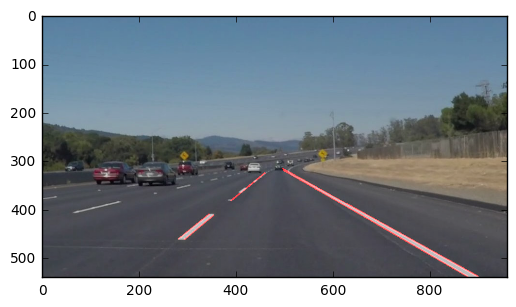

In [6]:
img = mpimg.imread('test_images/solidWhiteCurve.jpg')
img_shape= img.shape
img_gray = grayscale(img)
img_blur = gaussian_blur(img_gray, kernel_size=5)
img_edge = canny(img_blur, low_threshold=50, high_threshold=150)
vertices = np.array([[(0,img_shape[0]),(425, 315), (540, 315), (img_shape[1],img_shape[0])]], \
                        dtype=np.int32)
img_masked_edges = region_of_interest(img_edge, vertices)
img_hough_lines = hough_lines(img_masked_edges, rho=1, theta=np.pi/180, threshold=40,
                              min_line_len=60, max_line_gap=20)
img_lanes = weighted_img(img=img_hough_lines, initial_img=img, α=0.8, β=1., λ=0.)
plt.imshow(img_lanes)

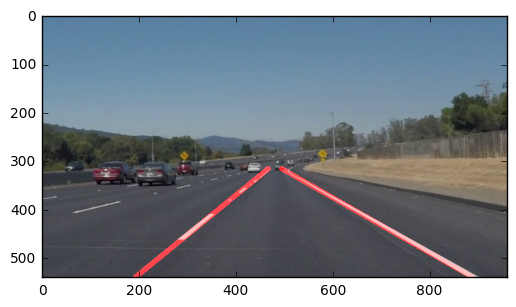

In [7]:
# Extrapolated lines
img_hough_lines_extrapolated = hough_lines(img_masked_edges, rho=1, theta=np.pi/180, threshold=40,
                              min_line_len=60, max_line_gap=20, extrapolate=True)
img_lanes_extrapolated = weighted_img(img=img_hough_lines_extrapolated, initial_img=img, α=0.8, β=1., λ=0.)
plt.imshow(img_lanes_extrapolated)

##### solidWhiteRight.jpg 

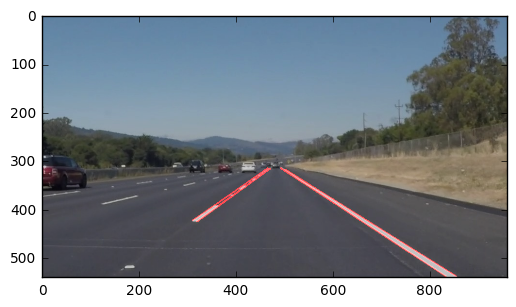

In [8]:
img = mpimg.imread('test_images/solidWhiteRight.jpg')
img_shape= img.shape
img_gray = grayscale(img)
img_blur = gaussian_blur(img_gray, kernel_size=5)
img_edge = canny(img_blur, low_threshold=50, high_threshold=150)
vertices = np.array([[(0,img_shape[0]),(425, 315), (540, 315), (img_shape[1],img_shape[0])]], \
                        dtype=np.int32)
img_masked_edges = region_of_interest(img_edge, vertices)
img_hough_lines = hough_lines(img_masked_edges, rho=1, theta=np.pi/180, threshold=40,
                              min_line_len=60, max_line_gap=40)
img_lanes = weighted_img(img=img_hough_lines, initial_img=img, α=0.8, β=1., λ=0.)

plt.imshow(img_lanes)

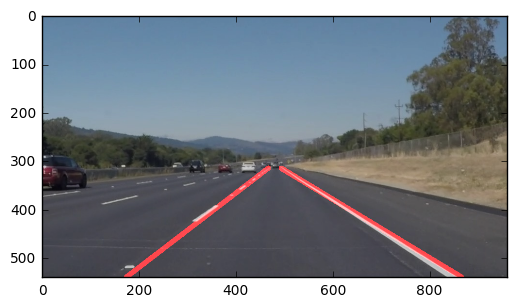

In [11]:
# Extrapolated lines
img_hough_lines_extrapolated = hough_lines(img_masked_edges, rho=1, theta=np.pi/180, threshold=40,
                              min_line_len=60, max_line_gap=40, extrapolate=True)
img_lanes_extrapolated = weighted_img(img=img_hough_lines_extrapolated, initial_img=img, α=0.8, β=1., λ=0.)
plt.imshow(img_lanes_extrapolated)

##### solidYellowCurve.jpg

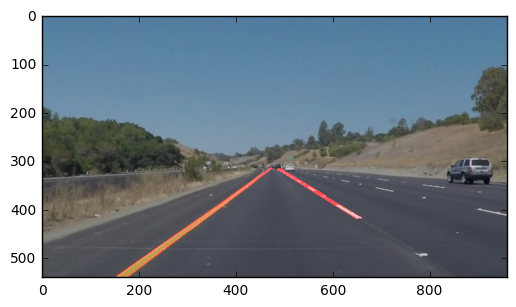

In [12]:
img = mpimg.imread('test_images/solidYellowCurve.jpg')
img_shape= img.shape
img_gray = grayscale(img)
img_blur = gaussian_blur(img_gray, kernel_size=5)
img_edge = canny(img_blur, low_threshold=50, high_threshold=150)
vertices = np.array([[(0,img_shape[0]),(425, 315), (540, 315), (img_shape[1],img_shape[0])]], \
                        dtype=np.int32)
img_masked_edges = region_of_interest(img_edge, vertices)
img_hough_lines = hough_lines(img_masked_edges, rho=1, theta=np.pi/180, threshold=40,
                              min_line_len=60, max_line_gap=30)
img_lanes = weighted_img(img=img_hough_lines, initial_img=img, α=0.8, β=1., λ=0.)

plt.imshow(img_lanes)

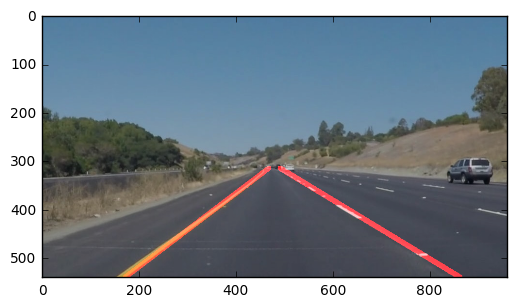

In [13]:
# Extrapolated lines
img_hough_lines_extrapolated = hough_lines(img_masked_edges, rho=1, theta=np.pi/180, threshold=40,
                              min_line_len=60, max_line_gap=30, extrapolate=True)
img_lanes_extrapolated = weighted_img(img=img_hough_lines_extrapolated, initial_img=img, α=0.8, β=1., λ=0.)
plt.imshow(img_lanes_extrapolated)

##### solidYellowCurve2.jpg

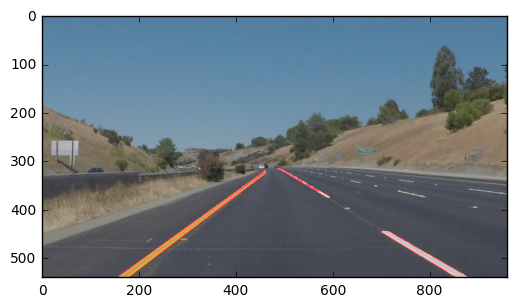

In [14]:
img = mpimg.imread('test_images/solidYellowCurve2.jpg')
img_shape= img.shape
img_gray = grayscale(img)
img_blur = gaussian_blur(img_gray, kernel_size=5)
img_edge = canny(img_blur, low_threshold=50, high_threshold=150)
vertices = np.array([[(0,img_shape[0]),(425, 315), (540, 315), (img_shape[1],img_shape[0])]], \
                        dtype=np.int32)
img_masked_edges = region_of_interest(img_edge, vertices)
img_hough_lines = hough_lines(img_masked_edges, rho=1, theta=np.pi/180, threshold=60,
                              min_line_len=60, max_line_gap=30)
img_lanes = weighted_img(img=img_hough_lines, initial_img=img, α=0.8, β=1., λ=0.)

plt.imshow(img_lanes)

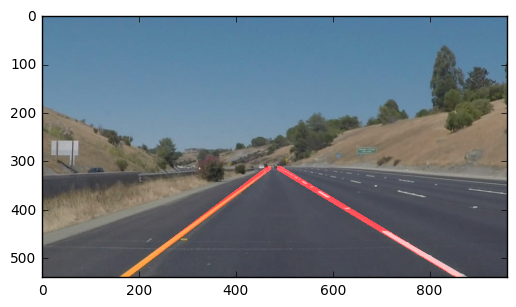

In [15]:
# Extrapolated lines
img_hough_lines_extrapolated = hough_lines(img_masked_edges, rho=1, theta=np.pi/180, threshold=60,
                              min_line_len=60, max_line_gap=30, extrapolate=True)
img_lanes_extrapolated = weighted_img(img=img_hough_lines_extrapolated, initial_img=img, α=0.8, β=1., λ=0.)
plt.imshow(img_lanes_extrapolated)

##### solidYellowLeft.jpg

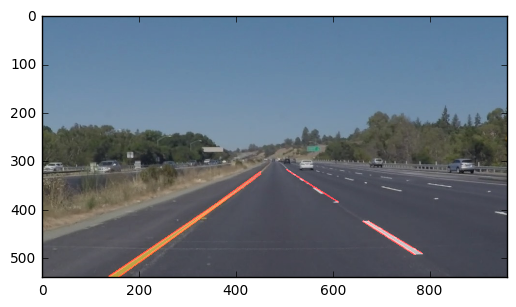

In [16]:
img = mpimg.imread('test_images/solidYellowLeft.jpg')
img_shape= img.shape
img_gray = grayscale(img)
img_blur = gaussian_blur(img_gray, kernel_size=5)
img_edge = canny(img_blur, low_threshold=50, high_threshold=150)
vertices = np.array([[(0,img_shape[0]),(425, 315), (540, 315), (img_shape[1],img_shape[0])]], \
                        dtype=np.int32)
img_masked_edges = region_of_interest(img_edge, vertices)
img_hough_lines = hough_lines(img_masked_edges, rho=1, theta=np.pi/180, threshold=60, 
                              min_line_len=60, max_line_gap=30)
img_lanes = weighted_img(img=img_hough_lines, initial_img=img, α=0.8, β=1., λ=0.)

plt.imshow(img_lanes)

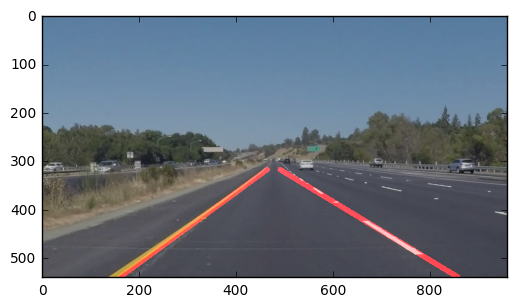

In [18]:
# Extrapolated lines
img_hough_lines_extrapolated = hough_lines(img_masked_edges, rho=1, theta=np.pi/180, threshold=60, 
                              min_line_len=60, max_line_gap=30, extrapolate=True)
img_lanes_extrapolated = weighted_img(img=img_hough_lines_extrapolated, initial_img=img, α=0.8, β=1., λ=0.)
plt.imshow(img_lanes_extrapolated)

##### whiteCarLaneSwitch.jpg

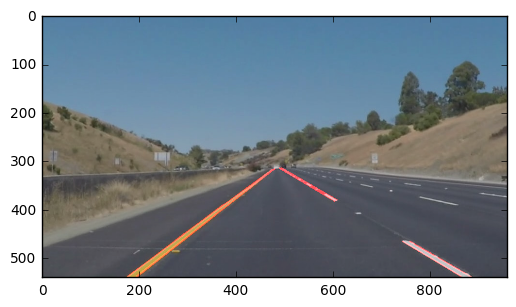

In [19]:
img = mpimg.imread('test_images/whiteCarLaneSwitch.jpg')
img_shape= img.shape
img_gray = grayscale(img)
img_blur = gaussian_blur(img_gray, kernel_size=5)
img_edge = canny(img_blur, low_threshold=50, high_threshold=150)
vertices = np.array([[(0,img_shape[0]),(425, 315), (540, 315), (img_shape[1],img_shape[0])]], \
                        dtype=np.int32)
img_masked_edges = region_of_interest(img_edge, vertices)
img_hough_lines = hough_lines(img_masked_edges, rho=1, theta=np.pi/180, threshold=80,
                              min_line_len=60, max_line_gap=30)
img_lanes = weighted_img(img=img_hough_lines, initial_img=img, α=0.8, β=1., λ=0.)

plt.imshow(img_lanes)

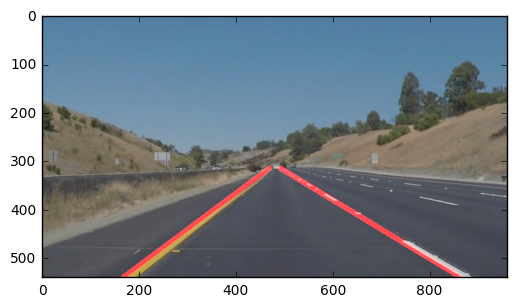

In [21]:
# Extrapolated lines
img_hough_lines_extrapolated = hough_lines(img_masked_edges, rho=1, theta=np.pi/180, threshold=80,
                              min_line_len=60, max_line_gap=30, extrapolate=True)
img_lanes_extrapolated = weighted_img(img=img_hough_lines_extrapolated, initial_img=img, α=0.8, β=1., λ=0.)
plt.imshow(img_lanes_extrapolated)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [22]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [23]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    img_shape= image.shape
    img_gray = grayscale(image)
    
    
    img_blur = gaussian_blur(img_gray, kernel_size=5)
    img_edge = canny(img_gray, low_threshold=50, high_threshold=100)
    # For challenge video, use different parameters below
    #img_blur = gaussian_blur(img_gray, kernel_size=3) # for challenge video
    #img_edge = canny(img_blur, low_threshold=5, high_threshold=170)  # for challenge video 

    
    # to make this function moregeneral, I am using % of height and width of each video frame,
    # rather than using explicit vertices that I used while processing images above 
    vertices = np.array([[(img_shape[1]*0.20,img_shape[0]),(img_shape[1]*0.40, img_shape[0]*0.60), 
                          (img_shape[1]*0.55, img_shape[0]*0.60), (img_shape[1],img_shape[0])]], dtype=np.int32)
    # For challenge video, use different parameters below 
    #vertices = np.array([[(img_shape[1]*0.10,img_shape[0]),(img_shape[1]*0.40, img_shape[0]*0.60), 
    #                      (img_shape[1]*0.55, img_shape[0]*0.60), (img_shape[1],img_shape[0])]], dtype=np.int32)
    
    
    img_masked_edges = region_of_interest(img_edge, vertices)
    
    
    # Update the parameters in hough_lines to make it work on all videos
    img_hough_lines_extrapolated = hough_lines(img_masked_edges, rho=1, theta=np.pi/180, threshold=40,
                              min_line_len=10, max_line_gap=70, extrapolate=True)
    # For Challenge video, use different paremeters below 
    #img_hough_lines_extrapolated = hough_lines(img_masked_edges, rho=0.5, theta=np.pi/360, threshold=8,
    #                          min_line_len=5, max_line_gap=150, extrapolate=True)
    
    img_lanes_extrapolated = weighted_img(img=img_hough_lines_extrapolated, initial_img=image, α=0.8, β=1., λ=0.)

    return img_lanes_extrapolated

### Let's try the one with the solid white lane on the right first ...

In [24]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:05<00:00, 37.91it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 3.76 s, sys: 689 ms, total: 4.45 s
Wall time: 5.98 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [25]:
#HTML("""
#<video width="960" height="540" controls>
#  <source src="https://youtu.be/VXccUjr322A">
#</video>
#""".format(white_output))

# Note: The above code didn't work well on my browser, so I'm using a differet method to display video output.

from IPython.display import YouTubeVideo
YouTubeVideo('https://youtu.be/VXccUjr322A')


**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [26]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:17<00:00, 37.86it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 12.3 s, sys: 2.26 s, total: 14.5 s
Wall time: 18.8 s


In [27]:
#HTML("""
#<video width="960" height="540" controls>
#  <source src="{0}">
#</video>
#""".format(yellow_output))

from IPython.display import YouTubeVideo
YouTubeVideo('https://youtu.be/t38wJ3V3Mi8')

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


- This was a fun project. Even though I was already familiar with Hough Transform, I learned a bit more about Hough Transform by fiddling with parameters. Parameter tuning is probably one of the most important skills in Computer Vision. 

- Brief description of my current pipeline:
  - I am first converting the color image (or a frame from a video) to a grayscale image. This enables us to work on a single channel of the image, instead of working on all 3 channels (BGR). So this is computationally less intensive
  - Then I am applying Gaussian Blur to the image. I also tried Bilateral Filtering, since this filtering preserves edges better, compared to Gaussian Filter. However, I did not see a big advantage in this project, so I kept the Gaussian Filtering in my code to be consistent with given specifications. 
  - Then I applied Canny Edge detection on this smoothed image. 
  - To make this process more efficent, I used a small GUI tool. 
    Here's the demo of the tool: https://youtu.be/xdiekchp-Uc 
  - On this Edge image, I filtered region of interest by applying a mask. Since we are primarily interested in edges in the region where we expect our road to be, I removed the edges in other areas of the image. 
  - Then I applied Hough Lines algorithm on this masked edge image. This gives us line segments where we have edges near the lane lines
  - Once I get the lane line segments, I extrapolated the left lane line and right lane line, based on the angle. 
  - Since we are using Polar coordinates in Hough Transform, our left line will have negative slope and the right line will have positive slope. Based on this, I classify each line segment to be either a left line segment or a right line segment. Then I take average of all left line segments and draw an extrapolated left line. I apply same method for extrapolating the right line segment as well. To make the extrapolated lines more stable and less wobbly, I applied weighted sum of previous slope and current slope of each line. This allows smooth transitioning of the slope, so the outcome looks more stable. 

- I think using simply Hough Transform algorithm is not very robust for finding lane lines. For example, Hough Transform may not work well when there is cross-walk nearby or when parts of the road are not painted. Unless we implement Hyperbola fitting in Hough Transform, the algorithm may not work very well on curvy roads. 

- To make algorithm work better:
  - We can probaly use K-means clustering in our region of interest. This will work well, if we simply want to follow our current lane. 
  - We can also do RANSAC. 
  - Another option could be using Histograms to do Sengmentation. 

## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [28]:
# Note: You will need to use the commented out parameters for the challenge video. 
# Reason: I used differnet parameters for the challenge video than the other two videos, to improve result
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:16<00:00, 15.73it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 13.2 s, sys: 2.2 s, total: 15.4 s
Wall time: 18.1 s


In [29]:
#HTML("""
#<video width="960" height="540" controls>
#  <source src="{0}">
#</video>
#""".format(challenge_output))

# Below is the output of challenge video:

from IPython.display import YouTubeVideo
YouTubeVideo('https://youtu.be/6eJAxwa-qDY')